In [87]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn, morris
from scipy.signal import correlate
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import numpy as np
import seaborn as sns
from ripser import ripser
from scipy.signal import detrend
import pandas as pd
import pickle
import time
import os
from scipy import signal as sp_signal
from scipy.stats import binned_statistic_2d
from scipy.stats import gaussian_kde
from collections import Counter
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

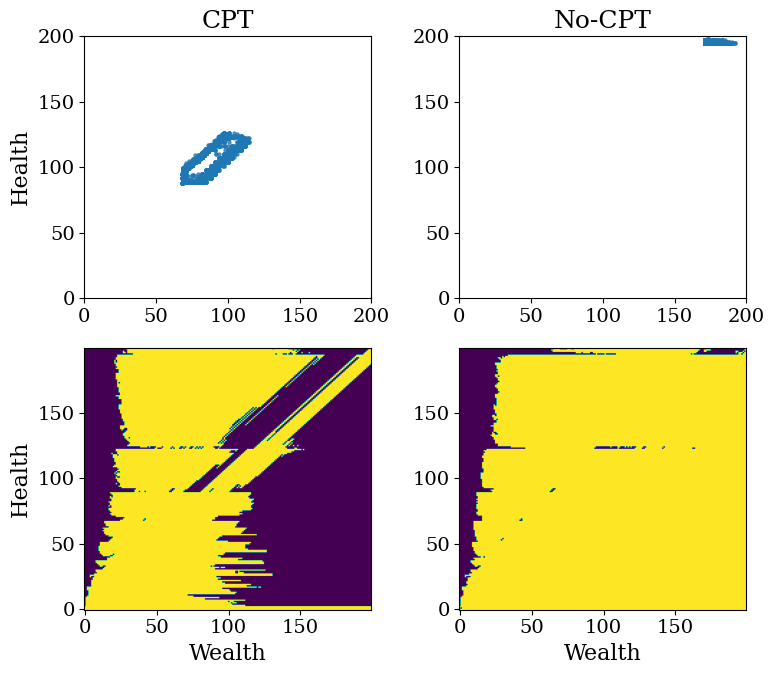

In [46]:
IDX = 547

fig, axs = plt.subplots(2, 2, figsize=(8,7))

cpt_P = None
nocpt_P = None

for idx, d in enumerate(["cpt/", "nocpt/"]):
    for i, file in enumerate(sorted(os.listdir(d))):
        if i == IDX:
            with open(d+file, "rb") as f:
                res = pickle.load(f)
            P = res["policy"]
            if d=="cpt/":
                cpt_P = P
                cpt_f = d+file
            else:
                nocpt_P = P
                nocpt_f = d+file
            break
    axs[0][idx].scatter(
        res["wealth"][:,-1],
        res["health"][:,-1],
        s=5,
        alpha=0.7
    )
    axs[0][idx].set_xlim(0,200)
    axs[0][idx].set_ylim(0,200)
    axs[1][idx].imshow(P.T, origin="lower", aspect="auto")

axs[0][0].set_title("CPT")
axs[0][1].set_title("No-CPT")
axs[0][0].set_ylabel("Health")
axs[1][0].set_ylabel("Health")

axs[1][0].set_xlabel("Wealth")
axs[1][1].set_xlabel("Wealth")

fig.tight_layout()
plt.show()

In [47]:
A = res["params"]["w_delta_scale"]
alpha = res["params"]["alpha"]
P_H_decrease = res["params"]["P_H_decrease"]
P_H_increase = res["params"]["P_H_increase"]

w_init = 20
h_init = 20

cpt_agent = (w_init, h_init)
cpt_util = [utility(w_init, h_init, alpha)]
cpt_pos = []

nocpt_agent = (w_init, h_init)
nocpt_util = [utility(w_init, h_init, alpha)]
nocpt_pos = []

num_steps = 5000

for s in tqdm(range(num_steps)):

    RN = np.random.uniform(0,1,1)

    # CPT
    w, h = cpt_agent
    w = int(w)
    h = int(h)
    cpt_decision = cpt_P[w-1, h-1]
    invest_cost = compute_health_cost(h)
    health_delta = compute_health_delta(h)

    if cpt_decision == 1 and w > invest_cost:
        new_w = compute_new_wealth(w-invest_cost, A, utility(w-invest_cost, h, alpha), 200)
        new_h = h
        if RN < P_H_increase:
            new_h = min(h + health_delta, 200)
        cpt_agent = (new_w, new_h)
        cpt_util.append(utility(new_w, new_h, alpha))
        cpt_pos.append(cpt_agent)
    else:
        new_w = compute_new_wealth(w, A, utility(w, h, alpha), 200)
        new_h = h
        if RN < P_H_decrease:
            new_h = max(1, h - health_delta)
        cpt_agent = (int(new_w), int(new_h))
        cpt_util.append(utility(new_w, new_h, alpha))
        cpt_pos.append(cpt_agent)
            
    # No CPT
    w, h = nocpt_agent
    w = int(w)
    h = int(h)
    nocpt_decision = nocpt_P[w-1, h-1]
    invest_cost = compute_health_cost(h)
    health_delta = compute_health_delta(h)

    if nocpt_decision == 1 and w > invest_cost:
        new_w = compute_new_wealth(w-invest_cost, A, utility(w-invest_cost, h, alpha), 200)
        new_h = h
        if RN < P_H_increase:
            new_h = min(h + health_delta, 200)
        nocpt_agent = (new_w, new_h)
        nocpt_util.append(utility(new_w, new_h, alpha))
        nocpt_pos.append(nocpt_agent)
    else:
        new_w = compute_new_wealth(w, A, utility(w, h, alpha), 200)
        new_h = h
        if RN < P_H_decrease:
            new_h = max(1, h - health_delta)
        nocpt_agent = (int(new_w), int(new_h))
        nocpt_util.append(utility(new_w, new_h, alpha))
        nocpt_pos.append(nocpt_agent)

  0%|          | 0/5000 [00:00<?, ?it/s]

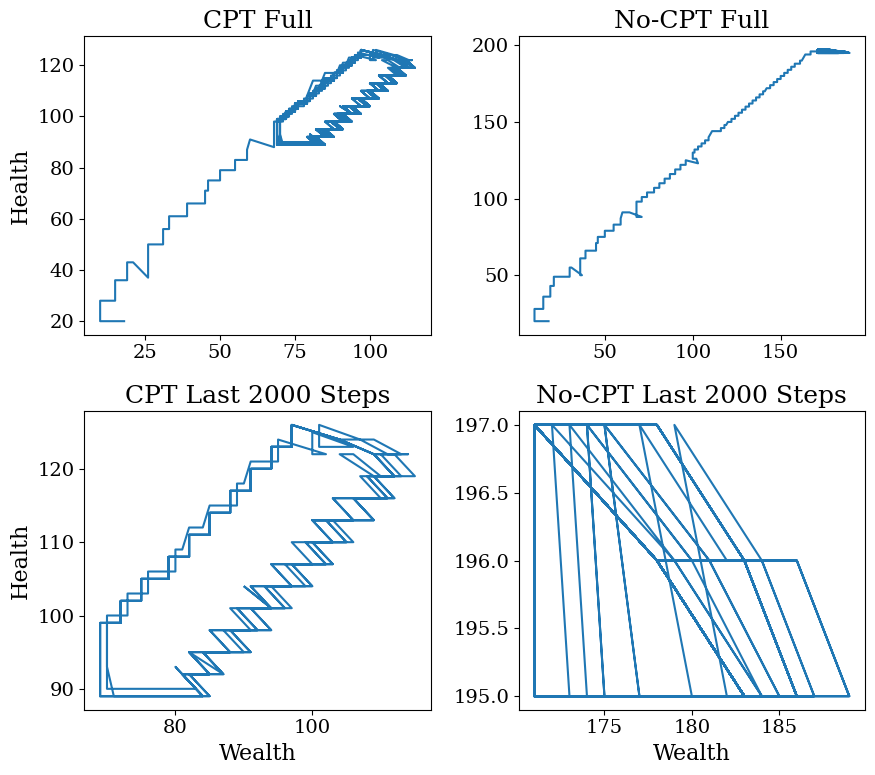

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(9,8))

timesteps = [num_steps, 2000]

for j, t in enumerate(timesteps):
    for i, arr in enumerate([cpt_pos, nocpt_pos]):
        axs[j][i].plot(
            [x[0] for x in arr[-t:]],
            [x[1] for x in arr[-t:]],
        )

axs[0][0].set_ylabel("Health")
axs[1][0].set_ylabel("Health")
axs[1][0].set_xlabel("Wealth")
axs[1][1].set_xlabel("Wealth")

axs[0][0].set_title("CPT Full")
axs[1][0].set_title(f"CPT Last {timesteps[-1]} Steps")
axs[0][1].set_title("No-CPT Full")
axs[1][1].set_title(f"No-CPT Last {timesteps[-1]} Steps")

fig.tight_layout()
plt.show()

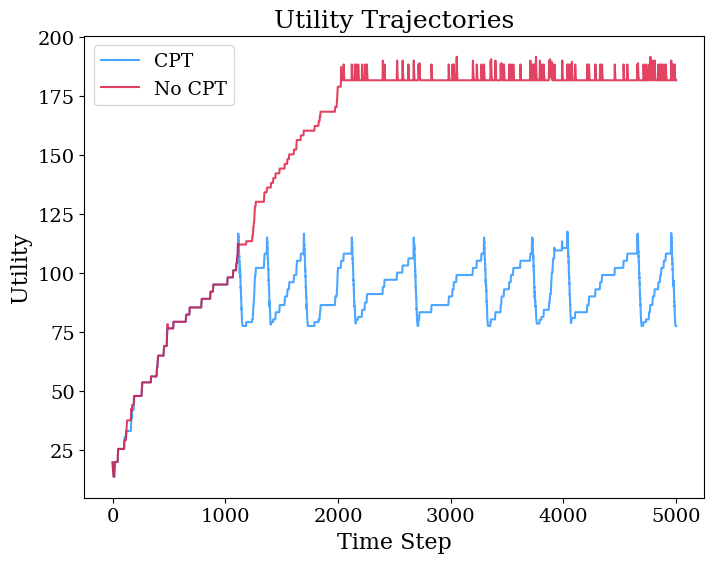

In [50]:
plt.plot(cpt_util, alpha=0.8, label="CPT", color="dodgerblue")
plt.plot(nocpt_util, alpha=0.8, label="No CPT", color="crimson")
plt.legend()

plt.title("Utility Trajectories")
plt.xlabel("Time Step")
plt.ylabel("Utility")
plt.show()

# Sliding Experiment

In [140]:
def compute_freqs(res, discard_steps=3000, power_threshold_ratio=0.20, trivial_range_threshold=0.0):
    w = res["wealth"][:, discard_steps:].astype(np.int16)
    h = res["health"][:, discard_steps:].astype(np.int16)
    u = utility(w, h, res["params"]["alpha"])

    # Threshold based on utility range during steady state
    u_last = u[:, -500:]
    u_range = np.max(u_last, axis=1) - np.min(u_last, axis=1)
    is_trivial = u_range < trivial_range_threshold

    dominant_frequencies = np.full(w.shape[0], np.nan)
    dominant_amplitudes = np.full(w.shape[0], np.nan)
    is_significant = ~is_trivial
    if not np.any(is_significant):
        return dominant_frequencies, dominant_amplitudes

    # Prepare and detrend signals
    u_to_process = u[is_significant]
    u = detrend(u_to_process, axis=1)

    # Apply Hann window
    N = u.shape[1]
    window = np.hanning(N)
    u_windowed = u * window

    # FFT with proper normalization (divide by N and window RMS correction)
    window_rms = np.sqrt(np.mean(window ** 2))
    fft_vals_complex = np.fft.fft(u_windowed, axis=1) / (N * window_rms)
    fft_freqs = np.fft.fftfreq(N, 1)

    # Positive frequencies only
    pos_mask = fft_freqs > 0
    fft_freqs_pos = fft_freqs[pos_mask]

    # Power spectral density
    psd = np.abs(fft_vals_complex[:, pos_mask])**2

    # Denoise by thresholding
    peak_power_per_agent = np.max(psd, axis=1, keepdims=True)
    peak_power_per_agent[peak_power_per_agent == 0] = 1
    power_threshold = power_threshold_ratio * peak_power_per_agent
    psd[psd < power_threshold] = 0

    # Find dominant frequency and corresponding amplitude
    dominant_idx = np.argmax(psd, axis=1)
    dominant_freq_vals = fft_freqs_pos[dominant_idx]
    dominant_power_vals = psd[np.arange(psd.shape[0]), dominant_idx]

    # Handle zero-power cases
    zero_power_mask = np.max(psd, axis=1) == 0
    dominant_freq_vals[zero_power_mask] = np.nan
    dominant_power_vals[zero_power_mask] = np.nan

    # Store results
    dominant_frequencies[is_significant] = dominant_freq_vals
    dominant_amplitudes[is_significant] = 2 * np.sqrt(dominant_power_vals)  # factor 2 for single-sided FFT

    return dominant_frequencies, dominant_amplitudes


### $\gamma$

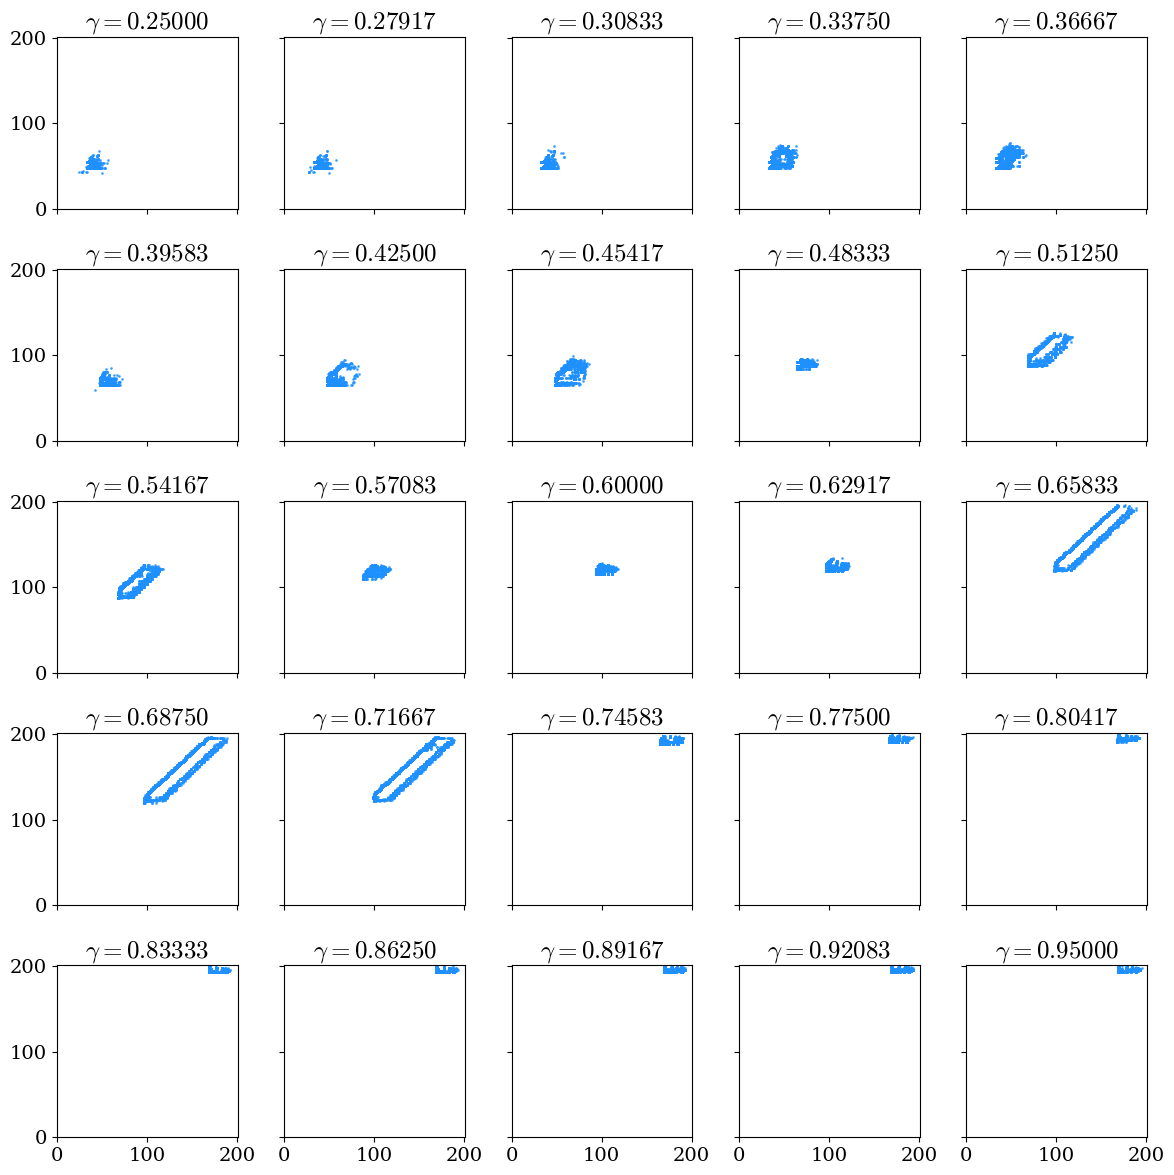

In [100]:
D = "slide_gamma/"
IDX = 3
ordered_files = sorted(os.listdir(D), key=lambda x: float(x.split("_")[IDX]))
fig, axs = plt.subplots(5, 5, figsize=(12,12), sharex=True, sharey=True)

for idx, file in enumerate(ordered_files):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    gamma = float(file.split("_")[IDX])
    axs[int(idx/5)][idx%5].scatter(
        res["wealth"][:,-1],
        res["health"][:,-1],
        s=1,
        alpha=0.7,
        color="dodgerblue"
    )
    axs[int(idx/5)][idx%5].set_xlim(0,201)
    axs[int(idx/5)][idx%5].set_ylim(0,201)
    axs[int(idx/5)][idx%5].set_title(fr"$\gamma={gamma:.5f}$")

fig.tight_layout()
plt.show()

In [135]:
ordered_files = sorted(os.listdir(D), key=lambda x: float(x.split("_")[IDX]))
freq = []
amp = []
for idx, file in tqdm(enumerate(ordered_files)):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    freqs, amps = compute_freqs(res)
    freq.append(np.mean(freqs[~np.isnan(freqs)]))
    amp.append(np.mean(amps[~np.isnan(freqs)]))

0it [00:00, ?it/s]

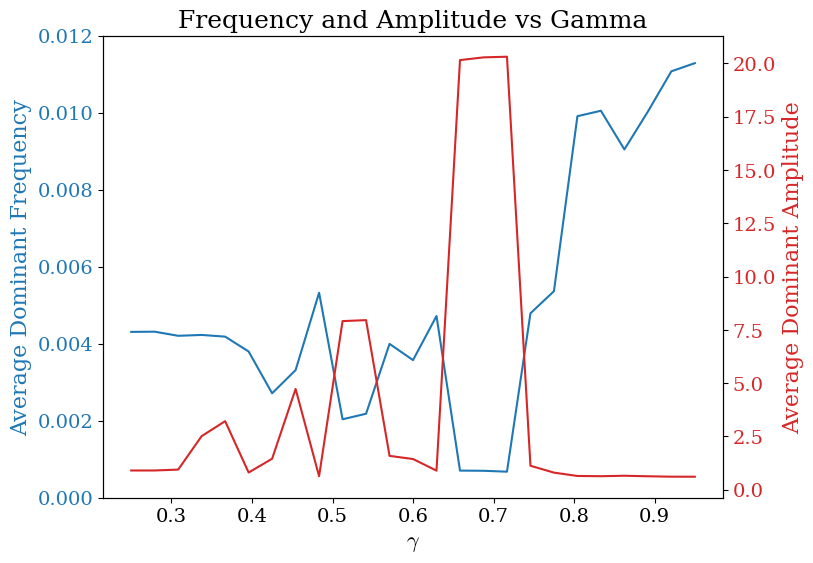

In [136]:
gamma = np.linspace(0.25, 0.95, 25)

fig, ax1 = plt.subplots()

# Primary axis (freq)
ax1.plot(gamma, freq, color='tab:blue')
ax1.set_xlabel(r"$\gamma$")
ax1.set_ylabel("Average Dominant Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 0.012)

# Secondary axis (amp)
ax2 = ax1.twinx()
ax2.plot(gamma, amp, color='tab:red')
ax2.set_ylabel("Average Dominant Amplitude", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Frequency and Amplitude vs Gamma")
plt.show()

### $\omega$

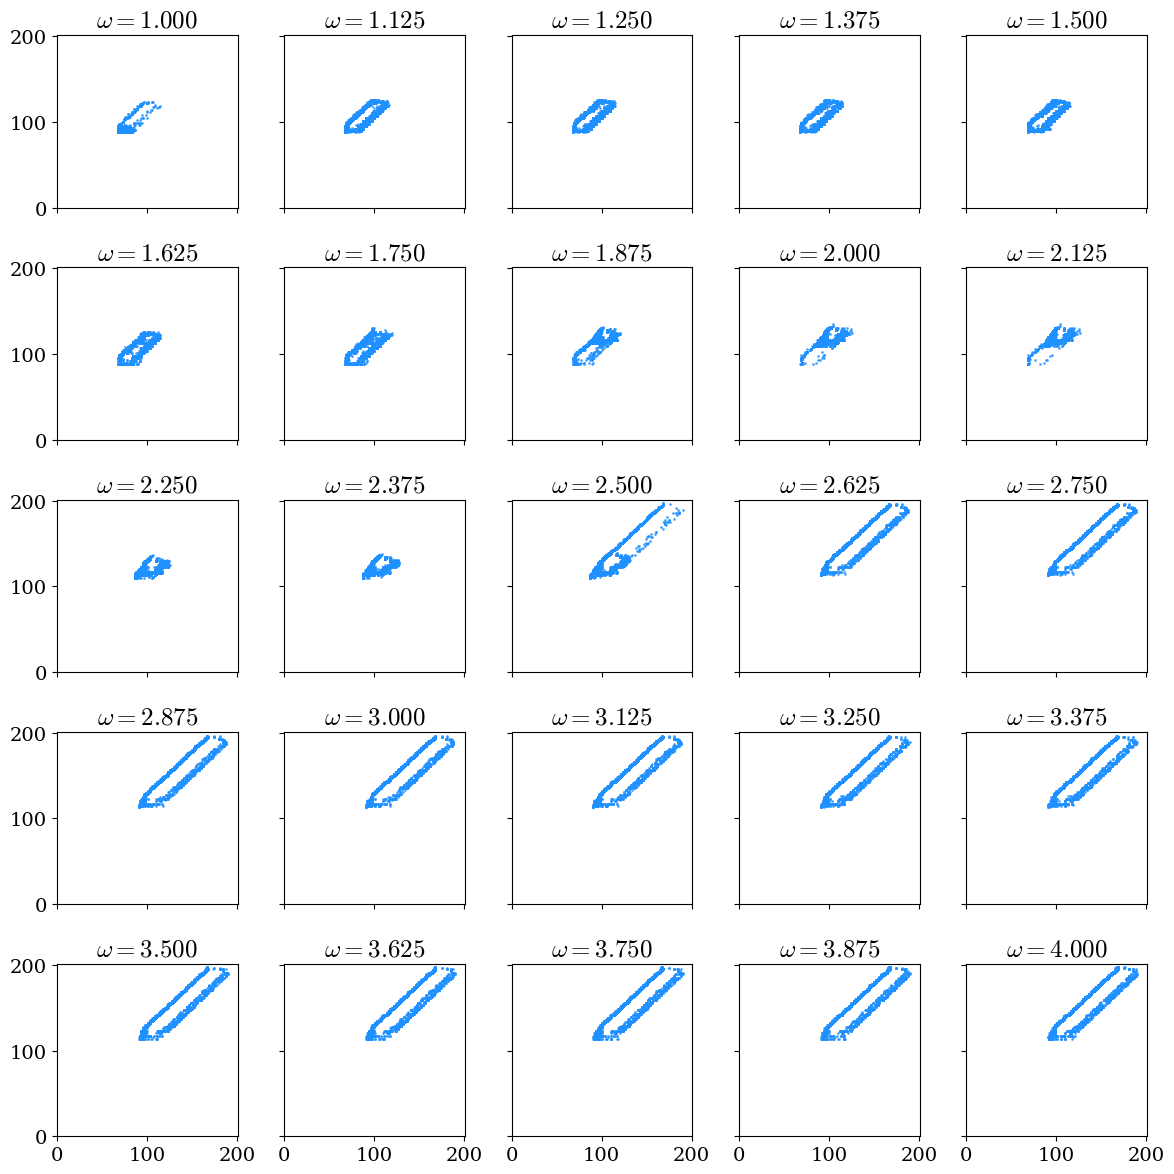

In [169]:
D = "slide_omega/"
IDX = 5
ordered_files = sorted(os.listdir(D), key=lambda x: float(x.split("_")[IDX]))

fig, axs = plt.subplots(5, 5, figsize=(12,12), sharex=True, sharey=True)

for idx, file in enumerate(ordered_files):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    omega = float(file.split("_")[IDX])
    axs[int(idx/5)][idx%5].scatter(
        res["wealth"][:,-1],
        res["health"][:,-1],
        s=1,
        alpha=0.7,
        color="dodgerblue"
    )
    axs[int(idx/5)][idx%5].set_xlim(0,201)
    axs[int(idx/5)][idx%5].set_ylim(0,201)
    axs[int(idx/5)][idx%5].set_title(fr"$\omega={omega:.3f}$")

fig.tight_layout()
plt.show()

In [170]:
ordered_files = sorted(os.listdir(D), key=lambda x: float(x.split("_")[IDX]))
freq = []
amp = []
for idx, file in tqdm(enumerate(ordered_files)):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    freqs, amps = compute_freqs(res)
    freq.append(np.mean(freqs[~np.isnan(freqs)]))
    amp.append(np.mean(amps[~np.isnan(freqs)]))

0it [00:00, ?it/s]

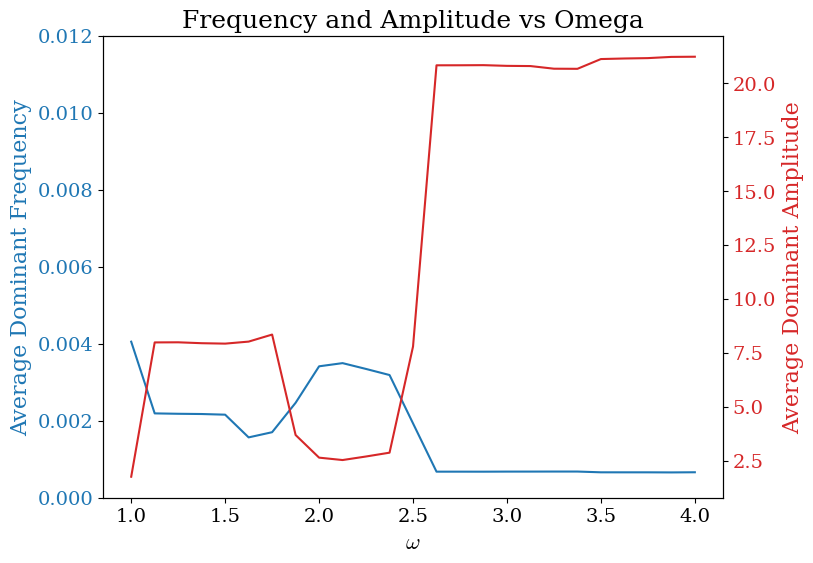

In [171]:
omega = np.linspace(1, 4, 25)

fig, ax1 = plt.subplots()

# Primary axis (freq)
ax1.plot(omega, freq, color='tab:blue')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel("Average Dominant Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 0.012)

# Secondary axis (amp)
ax2 = ax1.twinx()
ax2.plot(omega, amp, color='tab:red')
ax2.set_ylabel("Average Dominant Amplitude", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Frequency and Amplitude vs Omega")
plt.show()

### $\eta$

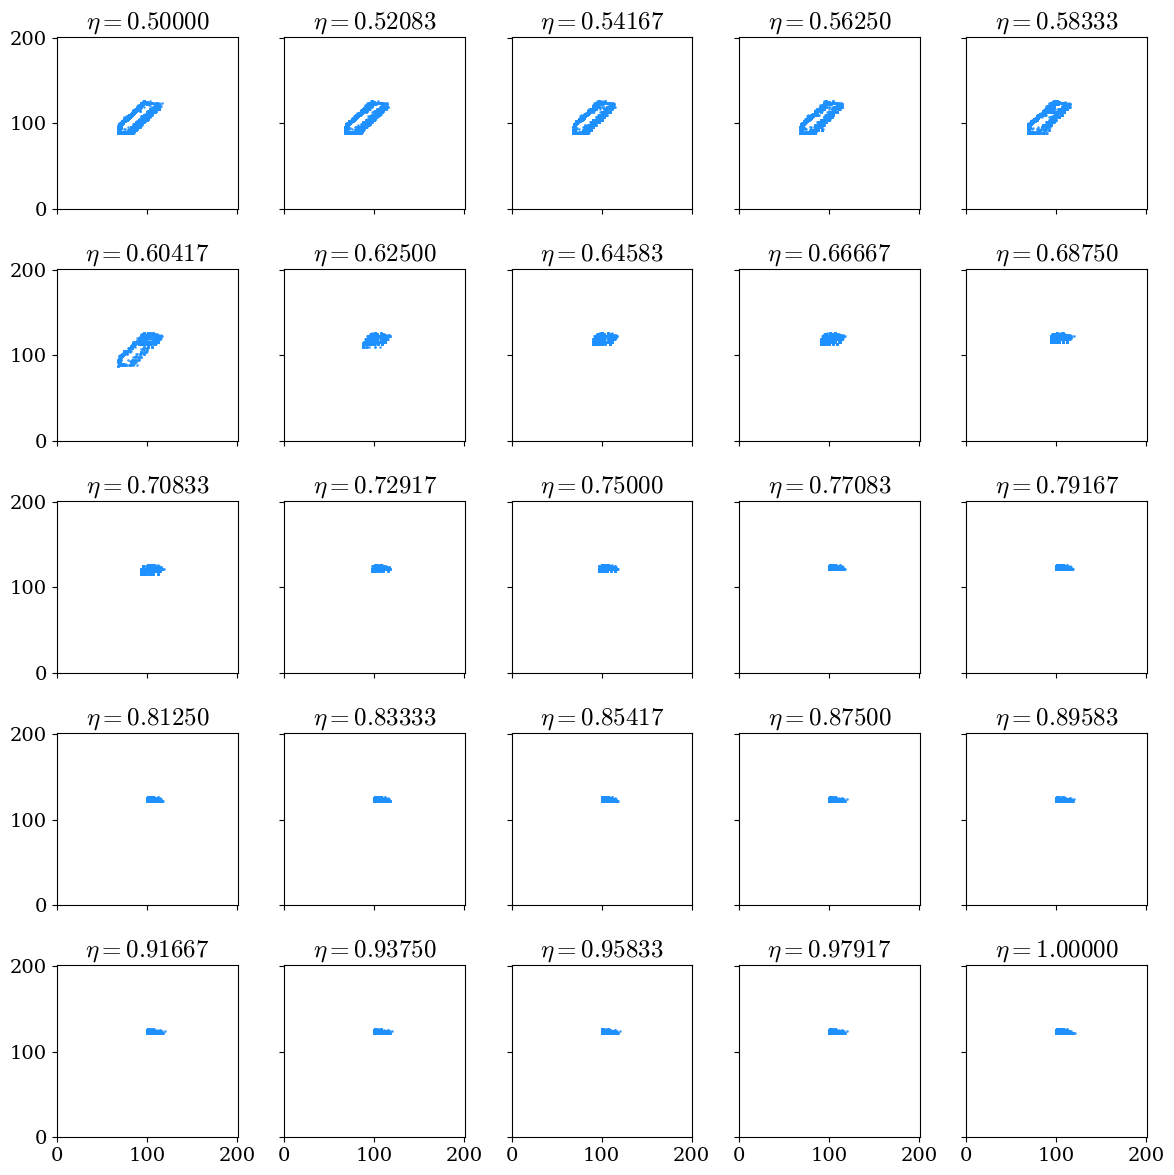

In [172]:
D = "slide_eta/"
IDX = 6
ordered_files = sorted(os.listdir(D), key=lambda x: float(x.split("_")[IDX].replace(".pickle", "")))
fig, axs = plt.subplots(5, 5, figsize=(12,12), sharex=True, sharey=True)

for idx, file in enumerate(ordered_files):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    eta = float(file.split("_")[IDX].replace(".pickle", ""))
    axs[int(idx/5)][idx%5].scatter(
        res["wealth"][:,-1],
        res["health"][:,-1],
        s=1,
        alpha=0.7,
        color="dodgerblue"
    )
    axs[int(idx/5)][idx%5].set_xlim(0,201)
    axs[int(idx/5)][idx%5].set_ylim(0,201)
    axs[int(idx/5)][idx%5].set_title(fr"$\eta={eta:.5f}$")

fig.tight_layout()
plt.show()

In [164]:
ordered_files = sorted(os.listdir(D), key=lambda x: float(x.split("_")[IDX].replace(".pickle", "")))
freq = []
amp = []
for idx, file in tqdm(enumerate(ordered_files)):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    freqs, amps = compute_freqs(res)
    freq.append(np.mean(freqs[~np.isnan(freqs)]))
    amp.append(np.mean(amps[~np.isnan(freqs)]))

0it [00:00, ?it/s]

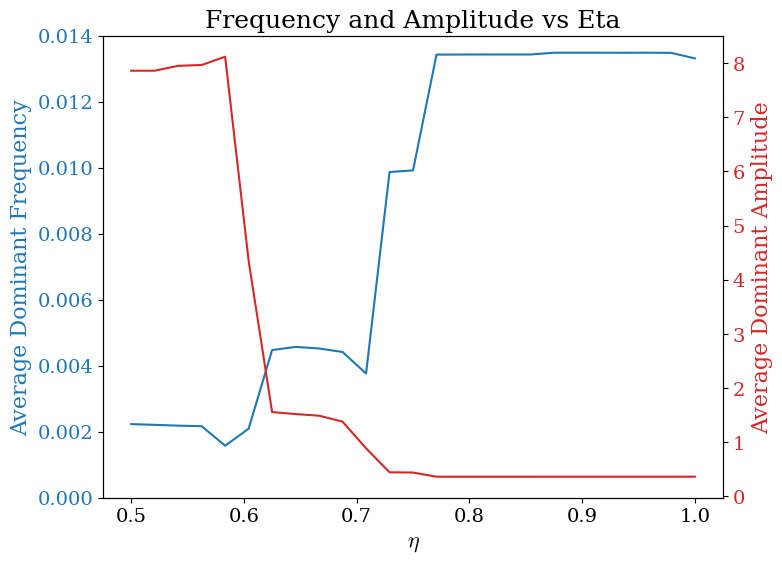

In [167]:
eta = np.linspace(0.5, 1, 25)

fig, ax1 = plt.subplots()

# Primary axis (freq)
ax1.plot(eta, freq, color='tab:blue')
ax1.set_xlabel(r"$\eta$")
ax1.set_ylabel("Average Dominant Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 0.014)

# Secondary axis (amp)
ax2 = ax1.twinx()
ax2.plot(eta, amp, color='tab:red')
ax2.set_ylabel("Average Dominant Amplitude", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Frequency and Amplitude vs Eta")
plt.show()